In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score

%matplotlib inline

In [55]:
# load training dataset
train_df = pd.read_csv('dataset/kaggle-house-price/train.csv')
rows_train = train_df.shape[0]
test_df = pd.read_csv('dataset/kaggle-house-price/test.csv')
all_data = pd.concat([train_df, test_df])

# null values
def null_values_per_col(df):
    """
    Returns a Pandas Series containing the number of null values for each
    column which has atleast 1 null value.
    """
    null_cols_all = df.apply(lambda x: x.size - x.count())
    null_cols = pd.Series()

    for col, val in null_cols_all.iteritems():
        if val > 0:
            null_cols[col] = val

    return null_cols

print "null values:"
null_values_per_col(all_data)

(1459, 80)
null values:


Alley           2721
BsmtCond          82
BsmtExposure      82
BsmtFinSF1         1
BsmtFinSF2         1
BsmtFinType1      79
BsmtFinType2      80
BsmtFullBath       2
BsmtHalfBath       2
BsmtQual          81
BsmtUnfSF          1
Electrical         1
Exterior1st        1
Exterior2nd        1
Fence           2348
FireplaceQu     1420
Functional         2
GarageArea         1
GarageCars         1
GarageCond       159
GarageFinish     159
GarageQual       159
GarageType       157
GarageYrBlt      159
KitchenQual        1
LotFrontage      486
MSZoning           4
MasVnrArea        23
MasVnrType        24
MiscFeature     2814
PoolQC          2909
SalePrice       1459
SaleType           1
TotalBsmtSF        1
Utilities          2
dtype: int64

**Fill null values 'NA' wherever possible.**

In [56]:
def fill_cols_with_val(df, cols, val):
    """
    Fill the columns specified in the DataFrame df with val
    """
    for col in cols:
        df[col].fillna(val, inplace=True)

NA_cols = ['Alley', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
           'PoolQC', 'Fence', 'MiscFeature', 'FireplaceQu', 'BsmtFinType2',
           'BsmtFinType1', 'BsmtExposure', 'BsmtCond', 'BsmtQual']

# fill with 'NA'
fill_cols_with_val(all_data, NA_cols, 'NA')

# remaining columns with null values
null_values_per_col(all_data)

BsmtFinSF1         1
BsmtFinSF2         1
BsmtFullBath       2
BsmtHalfBath       2
BsmtUnfSF          1
Electrical         1
Exterior1st        1
Exterior2nd        1
Functional         2
GarageArea         1
GarageCars         1
GarageYrBlt      159
KitchenQual        1
LotFrontage      486
MSZoning           4
MasVnrArea        23
MasVnrType        24
SalePrice       1459
SaleType           1
TotalBsmtSF        1
Utilities          2
dtype: int64

**Fill rest of the null values with appropriate values.**

In [57]:
zero_cols = ['MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath',
             'BsmtHalfBath', 'BsmtUnfSF', 'GarageArea', 'GarageCars', 'TotalBsmtSF']

# fill with zero
fill_cols_with_val(all_data, zero_cols, 0)

mode_cols = ['Exterior1st', 'Exterior2nd', 'Electrical', 'Functional', 'KitchenQual',
             'MSZoning', 'SaleType', 'Utilities']

# fill with mode
for col in mode_cols:
    all_data[col].fillna(all_data[col].mode()[0], inplace=True)

all_data['MasVnrType'].fillna('None', inplace=True)
all_data['LotFrontage'].fillna(all_data['LotFrontage'].mean(), inplace=True)

# remaining columns with null values
null_values_per_col(all_data)

GarageYrBlt     159
SalePrice      1459
dtype: int64

**Encode categories using LabelEncoder**

In [58]:
# Encode categories
only_strings = all_data.select_dtypes(include=['object'])
only_strings = all_data.apply(LabelEncoder().fit_transform)
all_data[only_strings.columns.values] = only_strings
all_data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,197,356,0,1,3,0,4,4,512,0,...,8,0,1,6,261,0,0,110,53,2
1,563,0,0,1,3,0,4,1,716,0,...,8,0,1,4,603,0,244,83,26,1
2,254,365,0,1,3,0,4,2,332,0,...,8,0,1,4,307,0,0,108,52,2
3,292,283,0,1,3,0,1,4,116,0,...,8,0,1,5,181,0,0,25,20,0
4,462,479,0,1,4,0,4,0,469,0,...,8,0,1,7,504,0,149,107,50,2


**Find important features**

In [60]:
train_data = all_data[0:rows_train]
test_data = all_data[rows_train:]
test_data.drop('SalePrice', axis=1, inplace=True)

x_features = train_data.columns.values.tolist()
x_features.remove('SalePrice')
# remove 'GarageYrBlt' since its unimportant and no default can be applied.
x_features.remove('GarageYrBlt')

X = train_data[x_features]
y = train_data['SalePrice']

rfr = RandomForestRegressor()
rfr.fit(X, y)
feature_importance = rfr.feature_importances_

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


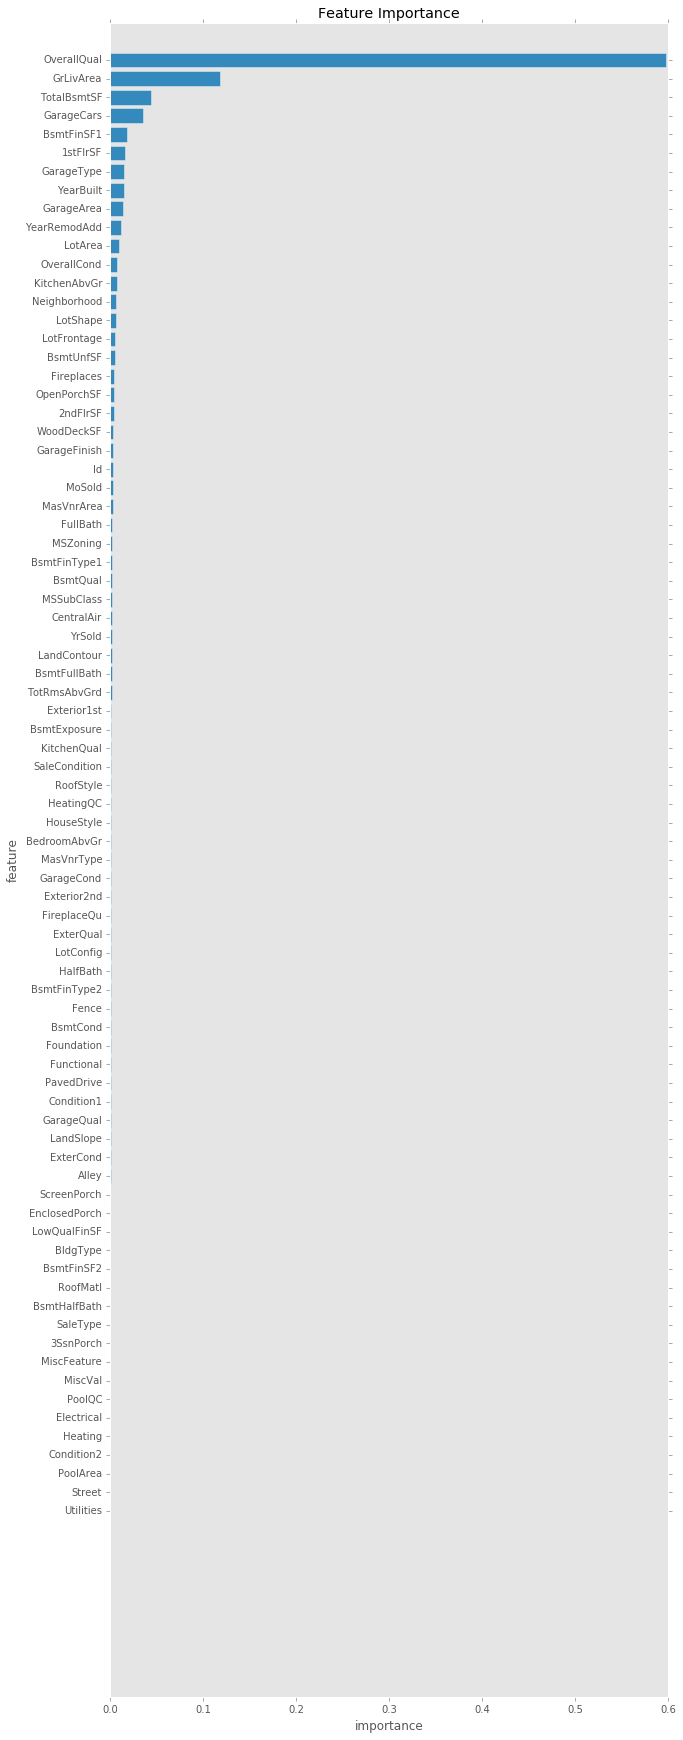

array(['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'GarageCars',
       'BsmtFinSF1', '1stFlrSF', 'GarageType', 'YearBuilt', 'GarageArea',
       'YearRemodAdd'], 
      dtype='|S13')

In [61]:
def plot_feature_importance(importances, features):
    """
    Plot the feature importances as a horizontal bar chart (in ascending order)
    x-axis = value of feature importance passed as the var 'importances'
    y-axis = feature name as labels passed as the var 'features'
    """
    sorted_idx = np.argsort(importances)
    sorted_importance = importances[sorted_idx]
    sorted_features = np.array(features)[sorted_idx]
    plt.barh(np.arange(len(sorted_importance)), sorted_importance,
         align='center')
    plt.yticks(range(len(sorted_features)), sorted_features)
    plt.xlabel("importance")
    plt.ylabel("feature")
    plt.title("Feature Importance")
    plt.grid()
    plt.show()

plt.style.use('ggplot')
plt.figure(figsize=[10, 30])
plot_feature_importance(feature_importance, x_features)

def top_n_features(importances, features, n=None):
    """
    Return the top n features
    """
    if not n:
        n = len(features)
    sorted_idx = np.argsort(importances)
    sorted_features = np.array(features)[sorted_idx][::-1]
    return sorted_features[: n]

top_10_features = top_n_features(feature_importance, x_features, 10)
top_10_features

In [62]:
X = X[top_10_features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=47)

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [63]:
y_true = y_test
r2_score(y_true, y_pred)

0.83623934658198129

In [70]:
test_X = test_data[top_10_features]
y_pred = lr.predict(test_X)
test_data['SalePrice'] = y_pred

id_price = test_data[['Id', 'SalePrice']]
id_price.to_csv('outputs/house_price_lin_reg1.csv', index=False)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
